<a href="https://colab.research.google.com/github/Differentlv/datasetproject/blob/main/Pemodelan_Sentimen_Analisis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**PEMODELAN SENTIMEN**

Instalisasi Library

In [ ]:
!pip install sastrawi
!pip install tensorflow
!pip install scikit-learn
!pip install pandas nltk wordcloud requests matplotlib seaborn
!pip install lightgbm xgboost catboost
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


Import Library

In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import requests
import json
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
import time
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import pickle


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Dataset

In [ ]:
df = pd.read_csv('/content/hasil_scraping_youtube.csv', encoding='utf-8', quotechar='"', escapechar='\\', on_bad_lines='skip')
# Membaca file CSV dari URL ke dalam DataFrame pandas

df.head() # Menampilkan 5 baris pertama dari DataFrame

,content,score
0,"update an terbaru youtube ini agak mengganggu,...",2
1,kok makin aneh ya? saat layar videonya di keci...,2
2,Padahal saya sudah setting resolusi yg tinggi ...,1
3,"Setelah update, sekarang aplikasinya saat mode...",1
4,tolong ya YouTube mendingan kalian perbaiki fi...,2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Cleaning

In [ ]:
clean_df = df.dropna()

In [ ]:
clean_df = clean_df.drop_duplicates()

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8998 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  8998 non-null   object
 1   score    8998 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 210.9+ KB


In [ ]:
clean_df.head()

,content,score
0,"update an terbaru youtube ini agak mengganggu,...",2
1,kok makin aneh ya? saat layar videonya di keci...,2
2,Padahal saya sudah setting resolusi yg tinggi ...,1
3,"Setelah update, sekarang aplikasinya saat mode...",1
4,tolong ya YouTube mendingan kalian perbaiki fi...,2


Pra-Pemrosesan Teks (Teks Preprocessing)

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word.lower() not in ["android", "youtube", "google", "youtube android"]])
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ya','loh','kah','deh'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
url = 'https://raw.githubusercontent.com/Differentlv/datasetproject/main/slangwords.json'

response = requests.get(url)

if response.status_code == 200:
    try:
        slangwords = json.loads(response.text)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        print("Response content:", response.text)
else:
    print("Failed to fetch data from URL. Status code:", response.status_code)

In [ ]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [ ]:
clean_df.head()

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"update an terbaru youtube ini agak mengganggu,...",2,update an terbaru ini agak mengganggu ad banya...,update an terbaru ini agak mengganggu ad banya...,update an terbaru ini agak mengganggu ada bany...,"[update, an, terbaru, ini, agak, mengganggu, a...","[update, terbaru, mengganggu, bug, menonton, s...",update terbaru mengganggu bug menonton short t...
1,kok makin aneh ya? saat layar videonya di keci...,2,kok makin aneh ya saat layar videonya di kecil...,kok makin aneh ya saat layar videonya di kecil...,kok makin aneh iya saat layar videonya di keci...,"[kok, makin, aneh, iya, saat, layar, videonya,...","[aneh, layar, videonya, kecilkan, pembesar, co...",aneh layar videonya kecilkan pembesar coba usa...
2,Padahal saya sudah setting resolusi yg tinggi ...,1,Padahal saya sudah setting resolusi yg tinggi ...,padahal saya sudah setting resolusi yg tinggi ...,padahal saya sudah atur resolusi yang tinggi d...,"[padahal, saya, sudah, atur, resolusi, yang, t...","[atur, resolusi, pengaturannya, pas, rendah, r...",atur resolusi pengaturannya pas rendah resolus...
3,"Setelah update, sekarang aplikasinya saat mode...",1,Setelah update sekarang aplikasinya saat mode ...,setelah update sekarang aplikasinya saat mode ...,setelah update sekarang aplikasinya saat mode ...,"[setelah, update, sekarang, aplikasinya, saat,...","[update, aplikasinya, mode, landscape, layar, ...",update aplikasinya mode landscape layar penuh ...
4,tolong ya YouTube mendingan kalian perbaiki fi...,2,tolong ya mendingan kalian perbaiki fitur subt...,tolong ya mendingan kalian perbaiki fitur subt...,minta bantuan iya mendingan kalian perbaiki fi...,"[minta, bantuan, iya, mendingan, kalian, perba...","[bantuan, mendingan, perbaiki, fitur, subtitle...",bantuan mendingan perbaiki fitur subtitle otom...


Pelabelan dan Ekstrasi Fitur

In [ ]:
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)

    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            parts = line.split(',')
            word = ','.join(parts[:-1])
            score = parts[-1]
            lexicon[word.strip()] = int(score.strip())
    else:
        print(f"Failed to fetch lexicon data from {url}")

    return lexicon

positive_lexicon_url = 'https://raw.githubusercontent.com/Differentlv/datasetproject/main/LeksikonPositif.txt'
negative_lexicon_url = 'https://raw.githubusercontent.com/Differentlv/datasetproject/main/LeksikonNegatif.txt'
neutral_lexicon_url = 'https://raw.githubusercontent.com/Differentlv/datasetproject/main/LeksikonNetral.txt'

# Memuat leksikon positif dan negatif dari URL yang diberikan
lexicon_positive = load_lexicon(positive_lexicon_url)
lexicon_negative = load_lexicon(negative_lexicon_url)
lexicon_neutral = load_lexicon(neutral_lexicon_url)

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    for word in text:
        if (word in lexicon_neutral):
            scroe = score + lexicon_neutral[word]

    polarity = ''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    elif (score == 0):
        polarity = 'neutral'

    return score, polarity

In [ ]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)

results = list(zip(*results))

clean_df['polarity_score'] = results[0]

clean_df['polarity'] = results[1]

print("Jumlah ulasan berdasarkan polaritas:")
print(clean_df['polarity'].value_counts())

print("\nUlasan dengan polaritas netral:")
neutral_reviews_df = clean_df[clean_df['polarity'] == 'neutral']
display(neutral_reviews_df[['content', 'polarity_score', 'polarity']])

Jumlah ulasan berdasarkan polaritas:
polarity
negative    5103
positive    2940
neutral      955
Name: count, dtype: int64

Ulasan dengan polaritas netral:


,content,polarity_score,polarity
3,"Setelah update, sekarang aplikasinya saat mode...",0,neutral
25,"Aplikasi nya sih bagus, cuman subtitle nya gaj...",0,neutral
26,"Tolong bisa tidak diperbaiki untuk bug, dimana...",0,neutral
104,"satu yg sepertinya harus ditingkatkan, yaitu f...",0,neutral
108,"pada saat melihat short, baru saja scroll 4-6 ...",0,neutral
...,...,...,...
8951,Tolong hadirkan kembali youtube go..!!!! Dan k...,0,neutral
8953,Sebuah Applikasi yang Multifungsi dan bisa jug...,0,neutral
8972,"kebanyakan iklan, lagi nonton musik atau anime...",0,neutral
8980,Kok belakangan ini update YouTube sekarang bug...,0,neutral


In [ ]:
neutral_reviews_df = clean_df[clean_df['polarity'] == 'neutral']
display(neutral_reviews_df[['content', 'polarity_score', 'polarity']])

,content,polarity_score,polarity
3,"Setelah update, sekarang aplikasinya saat mode...",0,neutral
25,"Aplikasi nya sih bagus, cuman subtitle nya gaj...",0,neutral
26,"Tolong bisa tidak diperbaiki untuk bug, dimana...",0,neutral
104,"satu yg sepertinya harus ditingkatkan, yaitu f...",0,neutral
108,"pada saat melihat short, baru saja scroll 4-6 ...",0,neutral
...,...,...,...
8951,Tolong hadirkan kembali youtube go..!!!! Dan k...,0,neutral
8953,Sebuah Applikasi yang Multifungsi dan bisa jug...,0,neutral
8972,"kebanyakan iklan, lagi nonton musik atau anime...",0,neutral
8980,Kok belakangan ini update YouTube sekarang bug...,0,neutral


In [ ]:
X = clean_df['text_akhir']
y = clean_df['polarity']

Ekstraksi Fitur

In [ ]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)

In [ ]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,akun,aman,anak,aneh,apapun,aplikasi,aplikasinya,app,atur,audio,...,upload,usang,versi,video,videonya,vidio,wifi,youtube,youtubenya,yutub
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.299121,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.265367,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.120056,0.234331,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.541918,0.000000,...,0.0,0.0,0.0,0.101775,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.217286,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.848843,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,0.0,0.0,0.0,0.000000,0.0,0.287230,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
8994,0.0,0.0,0.0,0.000000,0.0,0.640755,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
8995,0.0,0.0,0.0,0.000000,0.0,0.160890,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.256436,0.0,0.0,0.0,0.0
8996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.103936,0.000000,0.407207,0.0,0.0,0.0,0.0


Data **Visualization**

Presentasi Polaritas

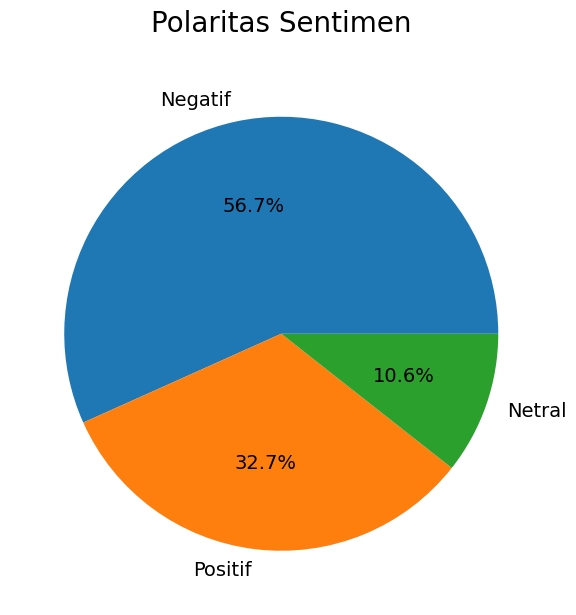

In [ ]:
fig, ax = plt.subplots(figsize=(7, 8))
sizes = [count for count in clean_df['polarity'].value_counts()]
#labels = list(clean_df['polarity'].value_counts().index)  # Mengambil nama kategori polaritas sentimen
labels = ['Negatif', 'Positif', 'Netral']
explode = (0, 0, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Polaritas Sentimen', fontsize=20, pad=22)
plt.show()

Gambar tersebut menunjukkan visualisasi sentimen dari ulasan pengguna terhadap aplikasi YouTube di Play Store. Dari diagram lingkaran, terlihat bahwa mayoritas pengguna memberikan ulasan negatif sebesar 56.7%. Sementara itu, ulasan positif berjumlah 32.7% dan sisanya 10.6% bersifat netral. Hal ini menunjukkan bahwa sebagian besar pengguna merasa kurang puas terhadap aplikasi YouTube, meskipun masih ada pengguna yang memberikan tanggapan positif dan netral.

Word Cloud

In [ ]:
positive_review = clean_df[clean_df['polarity'] == 'positive']
positive_review = positive_review[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_review = positive_review.sort_values(by='polarity_score', ascending=False)
positive_review = positive_review.reset_index(drop=True)
positive_review.index += 1

In [ ]:
negative_review = clean_df[clean_df['polarity'] == 'negative']
negative_review = negative_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_review = negative_review.sort_values(by='polarity_score', ascending=False)
negative_review = negative_review.reset_index(drop=True)
negative_review.index += 1

In [ ]:
neutral_review = clean_df[clean_df['polarity'] == 'neutral']
neutral_review = neutral_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_review = neutral_review.sort_values(by='polarity_score', ascending=False)
neutral_review = neutral_review.reset_index(drop=True)
neutral_review.index += 1

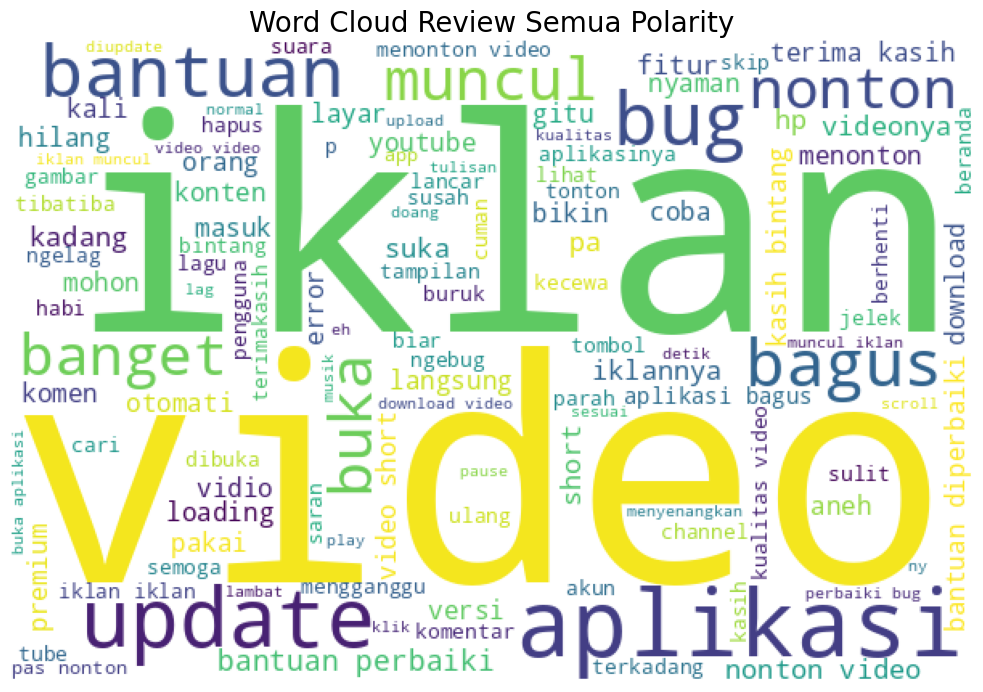

In [ ]:
list_words_collection = []
for tweet in clean_df['text_stopword']:
    if isinstance(tweet, list):
        list_words_collection.extend(tweet)
    elif isinstance(tweet, str):
        list_words_collection.extend(tweet.split())

list_words = ' '.join(list_words_collection)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Review Semua Polarity', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

Gambar ini memperlihatkan kata-kata yang sering muncul dalam semua ulasan, baik positif, negatif, maupun netral. Kata “iklan”, “video”, dan “aplikasi” mendominasi, menandakan bahwa topik iklan sangat sering dibahas pengguna. Selain itu, kata seperti “bug”, “bantuan”, dan “update” juga sering muncul, yang menunjukkan isu umum serta harapan pengguna terhadap peningkatan aplikasi.



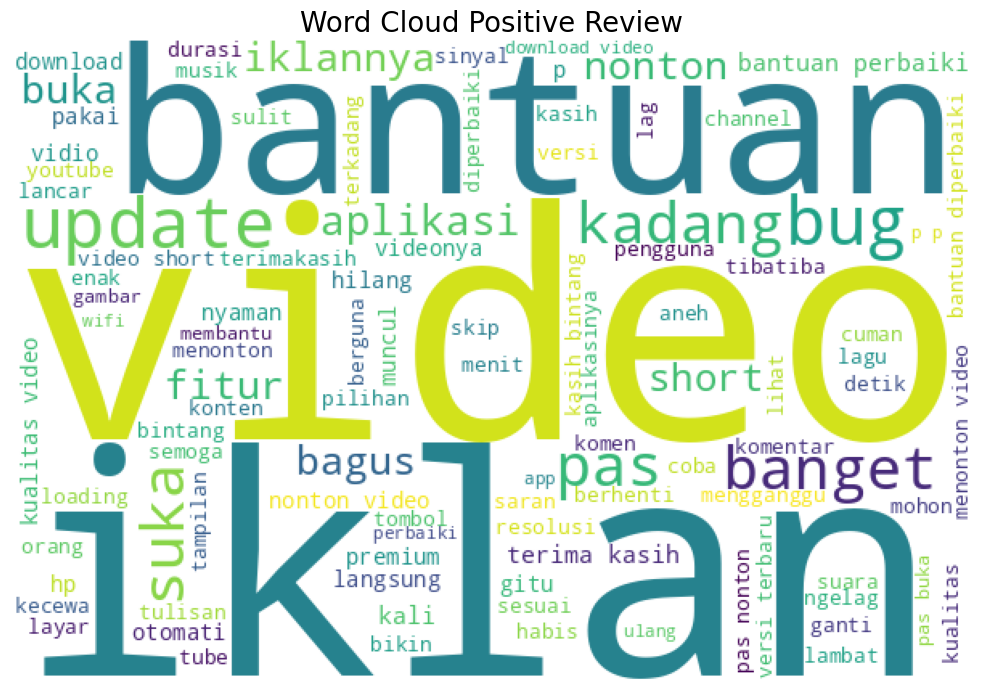

In [ ]:
list_words_collection = []
for review in positive_review['text_stopword']:
    if isinstance(review, list):
        list_words_collection.extend(review)
    elif isinstance(review, str):
        list_words_collection.extend(review.split())

list_words = ' '.join(list_words_collection)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Positive Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

Pada ulasan positif, kata yang paling menonjol adalah “bantuan”, “video”, dan “suka”. Ini menunjukkan bahwa beberapa pengguna merasa aplikasi ini bermanfaat, menyukai fitur-fiturnya, dan puas dengan pengalaman menonton video. Munculnya kata “fitur”, “update”, dan “bagus” juga mengindikasikan adanya apresiasi terhadap peningkatan dan kualitas layanan.

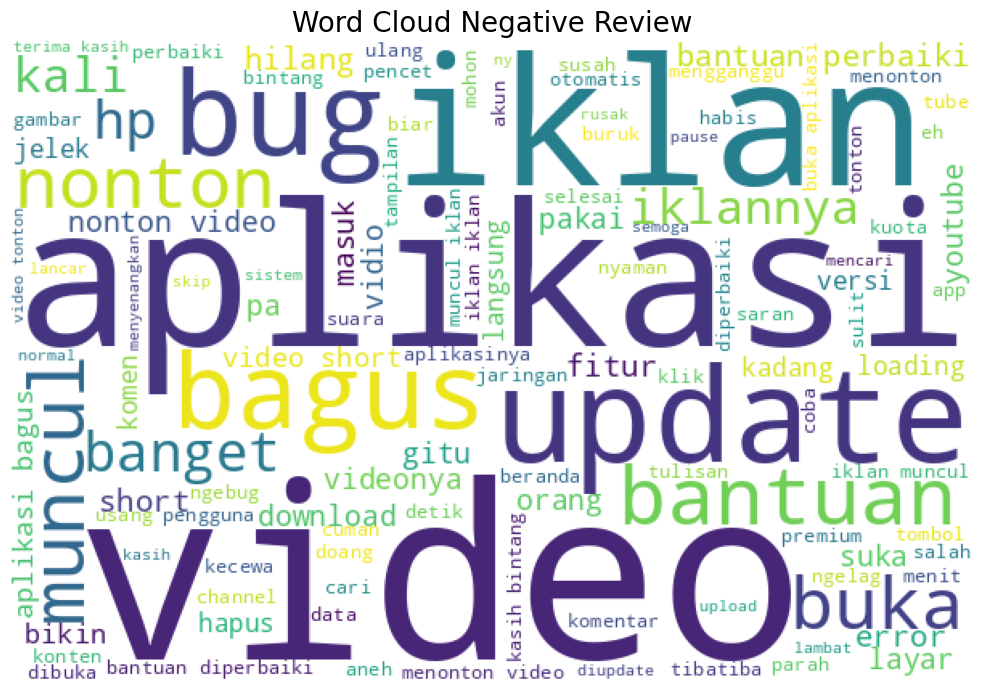

In [ ]:
list_words_collection = []
for review in negative_review['text_stopword']:
    if isinstance(review, list):
        list_words_collection.extend(review)
    elif isinstance(review, str):
        list_words_collection.extend(review.split())

list_words = ' '.join(list_words_collection)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Negative Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

Ulasan negatif didominasi oleh kata “iklan”, “bug”, dan “aplikasi”. Ini menunjukkan banyak keluhan mengenai banyaknya iklan yang mengganggu, bug atau error dalam aplikasi, serta kinerja aplikasi secara umum. Kata seperti “hilang”, “loading”, dan “ngelag” juga memperkuat bahwa banyak pengguna mengalami masalah teknis.

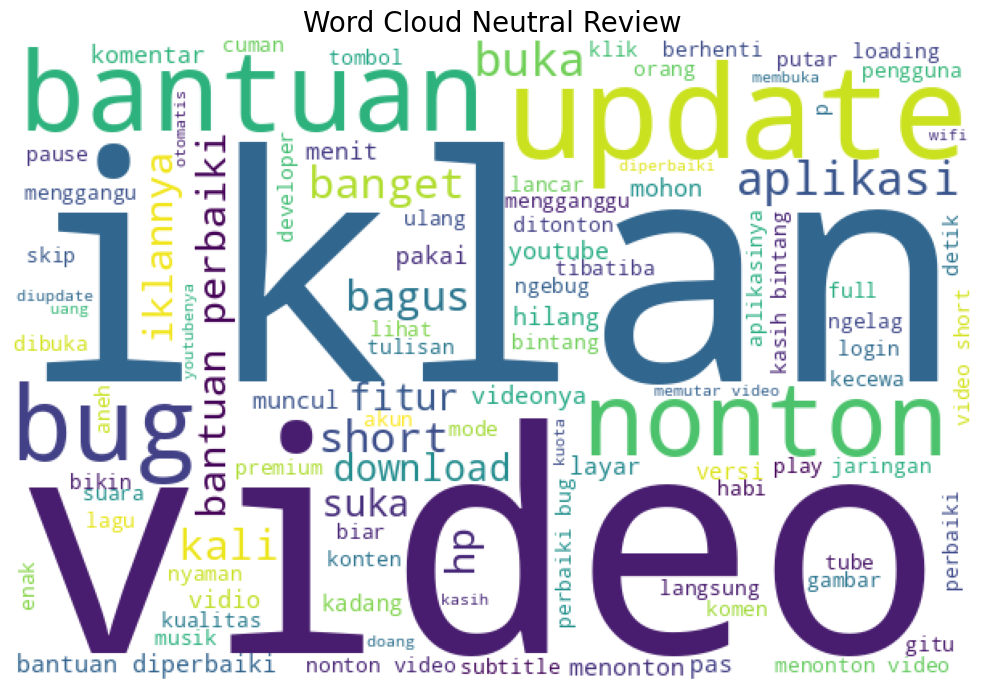

In [ ]:
list_words_collection = []
for review in neutral_review['text_stopword']:
    if isinstance(review, list):
        list_words_collection.extend(review)
    elif isinstance(review, str):
        list_words_collection.extend(review.split())

list_words = ' '.join(list_words_collection)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Neutral Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

Pada ulasan netral, kata “iklan”, “video”, dan “update” masih muncul dominan, menandakan bahwa pengguna netral tetap banyak membahas topik yang sama, namun tanpa emosi kuat. Kata seperti “bantuan”, “fitur”, dan “nonton” juga sering disebutkan, kemungkinan hanya sebagai informasi atau deskripsi pengalaman tanpa penilaian jelas.

Distribusi Kelas

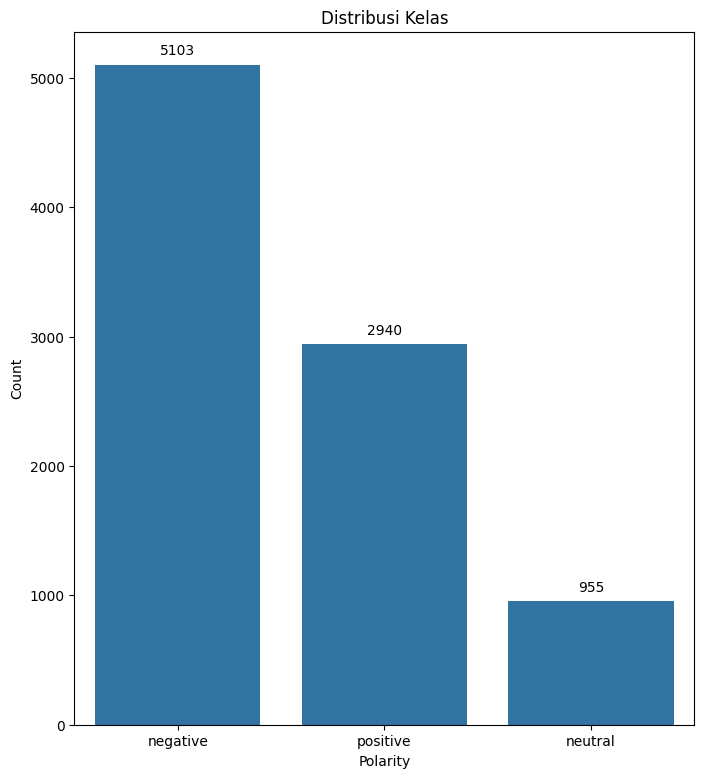

In [ ]:
# Mengatur ukuran gambar plot
plt.figure(figsize=(8, 9))

# Membuat plot count menggunakan seaborn untuk variabel 'polarity' dari dataframe 'clean_df'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)

# Menetapkan judul plot
plt.title('Distribusi Kelas')

# Menetapkan label sumbu x
plt.xlabel('Polarity')

# Menetapkan label sumbu y
plt.ylabel('Count')

# Menambahkan label angka untuk setiap bar pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

# Menampilkan plot
plt.show()

Permodelan

Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=50)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.7639622117254793
Logistic Regression - accuracy_test: 0.7566666666666667


XGBoost

In [ ]:
# Mengonversi sparse matrix ke array
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Melatih model XGBoost pada data pelatihan
start_time = time.time()
xgb.fit(X_train_array, y_train_encoded)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb = xgb.predict(X_train_array)
y_pred_test_xgb = xgb.predict(X_test_array)

# Evaluasi akurasi model XGBoost pada data pelatihan
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train_encoded)

# Evaluasi akurasi model XGBoost pada data uji
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test_encoded)

# Menampilkan akurasi dan waktu eksekusi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)
print('XGBoost - execution_time:', execution_time, 'seconds')


XGBoost - accuracy_train: 0.8894137260350097
XGBoost - accuracy_test: 0.725
XGBoost - execution_time: 5.935864448547363 seconds


CatBoost

In [ ]:
from catboost import CatBoostClassifier
import time

# Membuat objek model CatBoost
cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

# Melatih model CatBoost pada data pelatihan
start_time = time.time()
cat_model.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_cat = cat_model.predict(X_train.toarray())
y_pred_test_cat = cat_model.predict(X_test.toarray())

# Evaluasi akurasi model CatBoost pada data pelatihan
accuracy_train_cat = accuracy_score(y_pred_train_cat, y_train)

# Evaluasi akurasi model CatBoost pada data uji
accuracy_test_cat = accuracy_score(y_pred_test_cat, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('CatBoost - accuracy_train:', accuracy_train_cat)
print('CatBoost - accuracy_test:', accuracy_test_cat)
print('CatBoost - execution_time:', execution_time, 'seconds')

CatBoost - accuracy_train: 0.8045290358432898
CatBoost - accuracy_test: 0.7333333333333333
CatBoost - execution_time: 13.519560813903809 seconds


SVM

In [ ]:
# Membuat objek model SVM
svm = SVC(kernel='linear')

# Melatih model SVM pada data pelatihan
start_time = time.time()
svm.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM pada data pelatihan
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)

# Evaluasi akurasi model SVM pada data uji
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)
print('SVM - execution_time:', execution_time, 'seconds')

SVM - accuracy_train: 0.752014448457905
SVM - accuracy_test: 0.7411111111111112
SVM - execution_time: 7.474386215209961 seconds


Perbandingan Akurasi Model

In [ ]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Logistic Regression','Support Vector Machine','Extreme Gradient Boosting','Categorical Boosting'],
    'Accuracy Train': [accuracy_train_lr, accuracy_train_svm, accuracy_train_xgb, accuracy_train_cat],
    'Accuracy Test': [accuracy_test_lr, accuracy_test_svm, accuracy_test_xgb, accuracy_test_cat]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model','Accuracy Train', 'Accuracy Test']]

# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                       Model  Accuracy Train  Accuracy Test
0        Logistic Regression        0.763962       0.756667
1     Support Vector Machine        0.752014       0.741111
3       Categorical Boosting        0.804529       0.733333
2  Extreme Gradient Boosting        0.889414       0.725000


Model dengan akurasi tertinggi pada data uji adalah Logistic Regression dengan nilai 0.7567, diikuti oleh Support Vector Machine (0.7411). Meskipun model seperti Extreme Gradient Boosting dan Categorical Boosting memiliki akurasi train yang lebih tinggi (hingga 0.8894), hasil uji mereka justru lebih rendah (0.7250 dan 0.7333), yang menunjukkan kemungkinan overfitting.

Secara keseluruhan, Logistic Regression menjadi model yang paling stabil dan baik dalam generalisasi, karena memiliki keseimbangan antara akurasi train dan test.

Kesimpulan

In [ ]:
# Simpan model SVM
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

In [ ]:
# Simpan TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [ ]:
!pip freeze > requirements.txt